In [2]:
from qmcpy import *
import numpy as np
from pandas import *
import scipy as sc
from sympy import *
import matplotlib.pyplot as plt
from scipy.special import erf
import math

In [27]:
class RQMCEstimator:
    def __init__(self, n=1024, h=0.001,k=lambda x:1/np.sqrt(2*np.pi)*np.exp(-x**2/2),sequence='Sobol'):
        #self.g=lambda x:1/np.sqrt(2*np.pi)*np.exp(-x**2/2)
        self.n=n
        self.h=h
        self.k=k
        if sequence=='Sobol':
            self.sampler=Sobol(1).gen_samples(n)
            
        elif sequence=='Lattice':
            self.sampler=Lattice(1).gen_samples(n)
            
        else:
            raise ValueError("Invalid input. Must be Sobol or Lattice")  
    
    def mise(self):
        est=np.squeeze(self.density_estimation())
        #real_distrib=self.gaussian(self.points,2, 1) we define a distribution to estimate
        integrand=((est-real_distrib)*np.random.normal(2,1,self.m))**2
        ex=np.trapz(integrand)
        return ex
        return mise
    
    
    
class OptionEstimator(RQMCEstimator):
    def __init__(self, n=1024, h=0.001,k=lambda x:1/np.sqrt(2*np.pi)*np.exp(-x**2/2),sequence='Sobol', K=30, S0=50, T=1,
                 option='EPO'):
        super().__init__(n, h,k,sequence)
        self.option=option
        if option=='ECO': 
            self.T=T
            self.K=K
            r=0.1
            sigma=0.2
            self.S0=S0
        elif option=='EPO':
            self.T=T
            self.K=K
            r=0.1
            sigma=0.2
            self.S0=S0
        else:
            raise ValueError("Invalid input. Must be ECO or EPO")
        self.n=n 
        self.h=h
        self.k=k
        self.s=lambda x:self.S0*np.exp((r-sigma**2/2)*self.T+sigma*np.sqrt(self.T)*sc.stats.norm.ppf(x))
    def density_estimation(self,x):
        if self.option=='ECO':
            f=zeros(len(x),1)
            g=np.maximum(self.s(self.sampler)-self.K,0)
            for i in range (len(x)):
                for p in range (self.n):
                    f[i]+=(1/self.n)*(1/self.h)*self.k(((x[i]-g[p])/self.h))
            a=min(g)
            b=max(g)
            f2=[]
            i=0
            while True:
                sum=0
                for p in range (self.n):
                    sum+=(1/self.n)*(1/self.h)*self.k(((i*1-g[p])/self.h))
                f2.append(sum)
                if i*1>b:
                    break
                i=i+1
            r=np.linspace(0,i*1,i+1)
            f2=np.squeeze(f2)         
        else:
            f=zeros(len(x),1)
            g=np.maximum(self.K-self.s(self.sampler),0)
            for i in range (len(x)):
                for p in range (self.n):
                    f[i]+=(1/self.n)*(1/self.h)*self.k(((x[i]-g[p])/self.h))
            a=min(g)
            b=max(g)
            f2=[]
            i=0
            while True:
                sum=0
                for p in range (self.n):
                    sum+=(1/self.n)*(1/self.h)*self.k(((i*1-g[p])/self.h))
                f2.append(sum)
                if i*1>b:
                    break
                i=i+1
            r=np.linspace(0,i*1,i+1)
            f2=np.squeeze(f2)
        plt.figure()
        plt.plot(r,f2)
        plt.title("Density estimation")
        plt.xlabel("x")
        plt.ylabel("pdf")
        plt.show()
        print("Lower bound of estimation interval (a) is:",a)
        print("Upper bound of estimation interval (b) is:",b)
        return f,a,b   
    def mise(self):
        est=np.squeeze(self.density_estimation())
        #real_distrib=self.gaussian(self.points,2, 1) we define a distribution to estimate
        integrand=((est-real_distrib)*np.random.normal(2,1,self.m))**2
        ex=np.trapz(integrand)
        return ex
        return mise



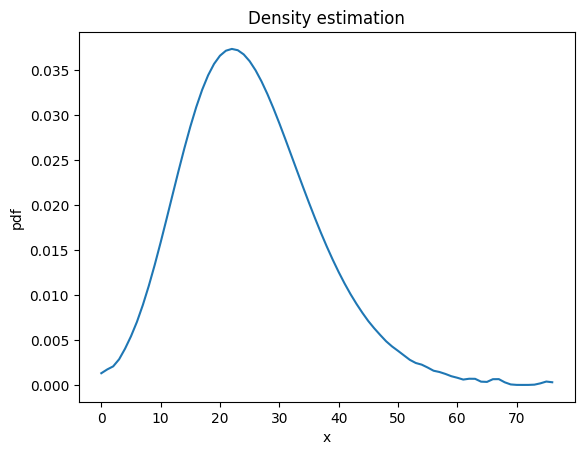

Lower bound of estimation interval (a) is: [0.]
Upper bound of estimation interval (b) is: [75.26459244]
Matrix([[0.00379617620505683]])


In [28]:
est=OptionEstimator(h=1, n=1024, option='ECO')
#x=np.linspace(0,1,1000)
x=[50]
f=est.density_estimation(x)
print(f[0])